In [1]:
from applicability_domain import ApplicabilityDomainDetector

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

### SEED

In [2]:
SEED = 334

### Sample data

In [3]:
boston = load_boston()
X = pd.DataFrame(boston['data'], columns = boston['feature_names'])
y = pd.Series(boston['target'], name = 'PRICE')

### train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

### Generate instance and fit

In [5]:
ad = ApplicabilityDomainDetector(k = 5, alpha = 0.9)
ad.fit(X_train)

ApplicabilityDomainDetector(alpha=0.9)

### inside or outside

In [6]:
boolean_train = ad.get_support(X_train)
boolean_test = ad.get_support(X_test)

### Comparison

In [7]:
rf = RandomForestRegressor(random_state = SEED, n_jobs = -1, n_estimators = 100)
rf.fit(X_train, y_train)
y_pred_on_train = rf.predict(X_train)
y_pred_on_test = rf.predict(X_test)

### MSE

Define function which return score

In [8]:
class score:
    def __init__(self, y_true, y_pred, name = ''):
        self.name = name
        self.y_true = y_true
        self.y_pred = y_pred
        self.score = mse(self.y_true, self.y_pred)
        print('MSE({0}): {1:.3f}'.format(self.name, self.score))

In [9]:
train_score = score(y_train, y_pred_on_train, name = 'train')

MSE(train): 1.746


In [10]:
test_score = score(y_test, y_pred_on_test, name = 'test')

MSE(test): 11.441


In [11]:
train_ad_score = score(y_train[boolean_train], y_pred_on_train[boolean_train], name = 'train_ad')

MSE(train_ad): 1.447


In [12]:
test_ad_score = score(y_test[boolean_test], y_pred_on_test[boolean_test], name = 'test_ad')

MSE(test_ad): 6.255


### Figuralization

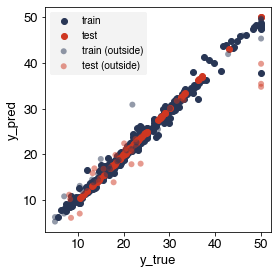

In [13]:
rcParams['font.size'] = 13
rcParams['font.family'] = 'Helvetica'

fig = plt.figure(facecolor = 'white')
ax = fig.add_subplot(111)

ax.scatter(train_ad_score.y_true, train_ad_score.y_pred, label = 'train', c = '#283655')
ax.scatter(test_ad_score.y_true, test_ad_score.y_true, label = 'test', c = '#cf3721')

ax.scatter(y_train[~boolean_train], y_pred_on_train[~boolean_train], label = 'train (outside)', c = '#283655', alpha = 0.5, edgecolor = 'None')
ax.scatter(y_test[~boolean_test], y_pred_on_test[~boolean_test], label = 'test (outside)', c = '#cf3721', alpha = 0.5, edgecolor = 'None')

ax.set_xlabel('y_true')
ax.set_ylabel('y_pred')

ax.set_aspect('equal')

ax.legend(facecolor = '#f0f0f0', edgecolor = 'None', fontsize = 10)

fig.tight_layout()

In [14]:
fig.savefig('example.png', dpi = 72)
plt.close()

### "How far is it?"

In [15]:
rd_train = ad.get_ratio_distance(X_train)
rd_test = ad.get_ratio_distance(X_test)
display(pd.Series(rd_train, dtype=np.float32, name='rd_train', index=X_train.index), pd.Series(rd_test, dtype=np.float32, name='rd_test', index=X_test.index))

196    0.623155
276    0.940595
497    0.317426
38     0.491921
7      0.584530
         ...   
91     0.373800
72     0.467204
162    1.335478
274    1.095346
130    0.366788
Name: rd_train, Length: 404, dtype: float32

99     0.672701
52     0.632384
360    0.807020
12     1.079990
56     0.722988
         ...   
297    1.011959
428    0.676207
329    1.017820
319    0.525903
286    1.066576
Name: rd_test, Length: 102, dtype: float32

In [16]:
np.all((rd_train <= 1) == boolean_train)

True

In [17]:
np.all((rd_test <= 1) == boolean_test)

True

mseとratio distanceの相関

In [18]:
def each_mse(y_true, y_pred):
    y_diff = np.square(y_true - y_pred)
    return y_diff

In [19]:
y_diff_train = each_mse(y_train, y_pred_on_train)
y_diff_test = each_mse(y_test, y_pred_on_test)

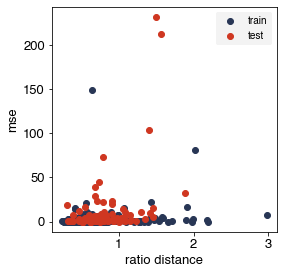

In [20]:
rcParams['font.size'] = 13
rcParams['font.family'] = 'Helvetica'

fig = plt.figure(facecolor = 'white')
ax = fig.add_subplot(111)

ax.scatter(rd_train, y_diff_train, label = 'train', c = '#283655')
ax.scatter(rd_test, y_diff_test, label = 'test', c = '#cf3721')

ax.set_xlabel('ratio distance')
ax.set_ylabel('mse')

ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

ax.legend(facecolor = '#f0f0f0', edgecolor = 'None', fontsize = 10)

fig.tight_layout()